# Recycling Multi-Classification Model


## Setup and Imports

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Preparation

### Define Transforms

In [ ]:
input_size = 224

train_transforms = transforms.Compose([
    # Resizes images to 224x224, consider using CenterCrop or pad is aspect ratio wanted to be preserved
    transforms.Resize((input_size, input_size)),
    # Randomly flips the image horizontally for data augmentation, improves generalization
    transforms.RandomHorizontalFlip(),
    # Converts image to PyTorch tensor
    transforms.ToTensor(),
    # Normalizes RGB
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Imagenet mean/std
])

val_test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Load Dataset

In [ ]:
data_dir = "../dataset/split"

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

## Define Model

In [4]:
# Plastic, Metal, Cardboard, Glass, Trash
target_classes = 5

# Load pretrained MobileNetV2 model (pretrained on ImageNet)
model = models.mobilenet_v2(pretrained=True)
# Replace final layer with custom classifier, how we adapt pretrained model to task.
model.classifier[1] = nn.Linear(model.last_channel, target_classes)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/Users/israelavendanojr./Desktop/project-repos/recycling-classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/israelavendanojr./Desktop/project-repos/recycling-classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

### Setup

In [9]:
# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

### Training Loop

In [ ]:
# Set batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Early stopping setup
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Loop for training
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero gradients from previous step
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

100%|██████████| 221/221 [26:11<00:00,  7.11s/it]


Epoch [1/5] Train Loss: 0.0797 | Train Acc: 97.43% | Val Loss: 0.2114 | Val Acc: 93.54%


100%|██████████| 221/221 [26:37<00:00,  7.23s/it]


Epoch [2/5] Train Loss: 0.0421 | Train Acc: 98.66% | Val Loss: 0.1731 | Val Acc: 95.12%


100%|██████████| 221/221 [26:28<00:00,  7.19s/it]


Epoch [3/5] Train Loss: 0.0473 | Train Acc: 98.36% | Val Loss: 0.2520 | Val Acc: 93.65%


100%|██████████| 221/221 [25:41<00:00,  6.98s/it]


Epoch [4/5] Train Loss: 0.0426 | Train Acc: 98.49% | Val Loss: 0.2448 | Val Acc: 92.97%


100%|██████████| 221/221 [25:51<00:00,  7.02s/it]


Epoch [5/5] Train Loss: 0.0264 | Train Acc: 99.07% | Val Loss: 0.2310 | Val Acc: 94.10%
Early stopping triggered.


### Save best model

In [ ]:
file = "best_model.pth"
if 'best_model_state' in locals():
    torch.save(best_model_state, file)
    print(f"Best model saved manually to {file}")
else:
    print("No best model to save")

Best model saved manually to best_model.pth


## Evaluation

In [ ]:
model.load_state_dict(torch.load(file))
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2032 | Test Accuracy: 95.26%


## Visualizations

### Confusion Matrix

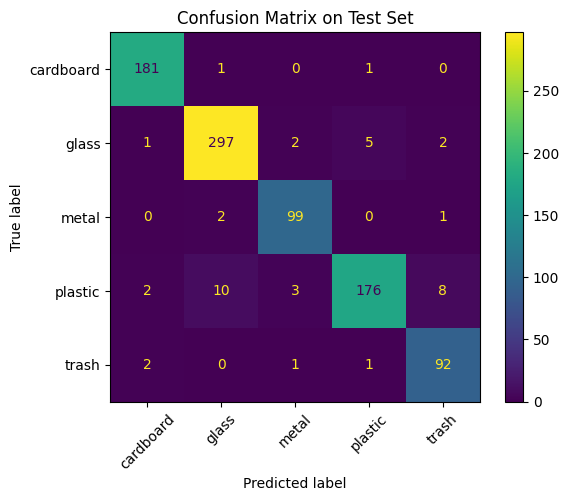

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

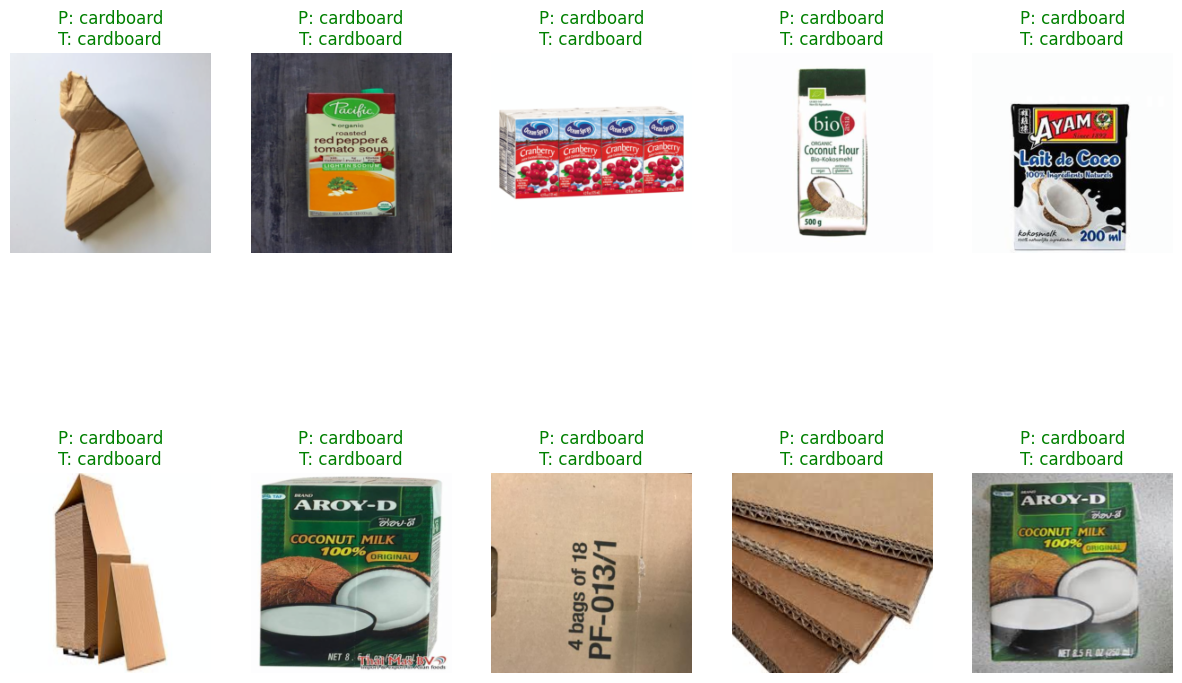

In [ ]:
def visualize_predictions(model, loader, num_images=10):
    model.eval()
    shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if shown == num_images:
                    return
                shown += 1
                plt.subplot(2, 5, shown)
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                plt.imshow(img)
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                color = "green" if true_label == pred_label else "red"
                plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
                plt.axis('off')

visualize_predictions(model, test_loader)